In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

In [110]:
properties = pd.read_csv('data/sales_data_2015.csv', index_col=0, low_memory=False)
properties.head()

,Sale_id,bbl_id,year,borough,bldg_ctgy,tax_cls_p,block,lot,easmnt,bldg_cls_p,...,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,usable,long,lat
0,1,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,...,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
1,2,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,...,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
2,3,230352,2015,2,01 ONE FAMILY DWELLINGS,1,3035,2,NaN,S1,...,1287,2528,1899,1,S1,12/18/2015,0,N,-73.898331,40.848648
3,4,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,...,2500,2452,1910,1,S1,08/18/2015,0,N,-73.893338,40.856136
4,5,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,...,2500,2452,1910,1,S1,07-01-15,400000,Y,-73.893338,40.856136


In [111]:
# print(len(properties['lot'].unique()))
# properties.iloc[1]

# Preprocessing

## Handling Missing & NaN Values

In [112]:
#Dropping rows with price, sqft and year = 0
print("Before:", len(properties))
properties = properties[(properties.yr_built != 0) & (properties.tot_sqft != 0) & (properties.price != 0)]
print("After:", len(properties))

Before: 84768
After: 28711


In [113]:
# #Dropping rows with price less than 10k, indiciates some family transfers and not everly useful in general
print("Before", len(properties[(properties['price'] < 10000)]))
properties = properties[properties.price > 10000]
print("After", len(properties[(properties['price'] < 10000)]))

print("Minimum price:", properties['price'].min())
print("Maximum price:", properties['price'].max())

Before 822
After 0
Minimum price: 10667
Maximum price: 555000000


In [114]:
properties.isna().sum().sort_values(ascending=False)

easmnt        27860
apt           27424
lat               0
long              0
bbl_id            0
year              0
borough           0
bldg_ctgy         0
tax_cls_p         0
block             0
lot               0
bldg_cls_p        0
address           0
zip               0
res_unit          0
com_unit          0
tot_unit          0
land_sqft         0
tot_sqft          0
yr_built          0
tax_cls_s         0
bldg_cls_s        0
sale_date         0
price             0
usable            0
Sale_id           0
dtype: int64

In [115]:
#Dropping nan columns
properties = properties.drop(['easmnt', 'apt'], axis=1)

In [116]:
properties.isna().sum().sort_values(ascending=False)

lat           0
long          0
bbl_id        0
year          0
borough       0
bldg_ctgy     0
tax_cls_p     0
block         0
lot           0
bldg_cls_p    0
address       0
zip           0
res_unit      0
com_unit      0
tot_unit      0
land_sqft     0
tot_sqft      0
yr_built      0
tax_cls_s     0
bldg_cls_s    0
sale_date     0
price         0
usable        0
Sale_id       0
dtype: int64

## Ignoring some less relevant columns

In [118]:
properties = properties.drop(['usable','res_unit','com_unit','sale_date', 
                              'address', 'bbl_id', 'Sale_id', 'year', 'lot', 'long','lat'], axis=1)

## Encoding class variables

In [119]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27860 entries, 4 to 84765
Data columns (total 13 columns):
borough       27860 non-null int64
bldg_ctgy     27860 non-null object
tax_cls_p     27860 non-null object
block         27860 non-null int64
bldg_cls_p    27860 non-null object
zip           27860 non-null int64
tot_unit      27860 non-null int64
land_sqft     27860 non-null int64
tot_sqft      27860 non-null int64
yr_built      27860 non-null int64
tax_cls_s     27860 non-null int64
bldg_cls_s    27860 non-null object
price         27860 non-null int64
dtypes: int64(9), object(4)
memory usage: 3.0+ MB


## Hot encoding

In [120]:
X_enc = properties.copy()
X_enc = pd.get_dummies(X_enc, columns=['bldg_ctgy','tax_cls_p','bldg_cls_p', 'bldg_cls_s'])

X_enc.head()
properties = X_enc
print(properties.shape)
properties.head()

(27860, 317)


,borough,block,zip,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,price,bldg_ctgy_01 ONE FAMILY DWELLINGS,...,bldg_cls_s_W2,bldg_cls_s_W3,bldg_cls_s_W6,bldg_cls_s_W7,bldg_cls_s_W8,bldg_cls_s_W9,bldg_cls_s_Y6,bldg_cls_s_Z0,bldg_cls_s_Z1,bldg_cls_s_Z9
4,2,3039,10458,2,2500,2452,1910,1,400000,1,...,0,0,0,0,0,0,0,0,0,0
7,2,2912,10457,2,2000,2400,1993,1,430000,0,...,0,0,0,0,0,0,0,0,0,0
9,2,2929,10457,2,3165,2394,1995,1,505000,0,...,0,0,0,0,0,0,0,0,0,0
10,2,3030,10457,3,1620,3240,1931,1,490000,0,...,0,0,0,0,0,0,0,0,0,0
12,2,3030,10457,2,1592,1860,1899,1,100000,0,...,0,0,0,0,0,0,0,0,0,0


## Outlier detection for prices and tot_sqft

In [121]:
from scipy import stats

z_score_price = np.abs(stats.zscore(properties['price']))
properties['z_score_price'] = z_score_price

z_score_tot_sqft = np.abs(stats.zscore(properties['tot_sqft']))
properties['z_score_tot_sqft'] = z_score_tot_sqft

print("Before shape:", properties.shape)

properties = properties[(properties.z_score_price < 3) & (properties.z_score_tot_sqft < 3)]
properties = properties.drop(['z_score_tot_sqft', 'z_score_price'], axis=1)

print("After shape:", properties.shape)

Before shape: (27860, 319)
After shape: (27638, 317)


# EDA

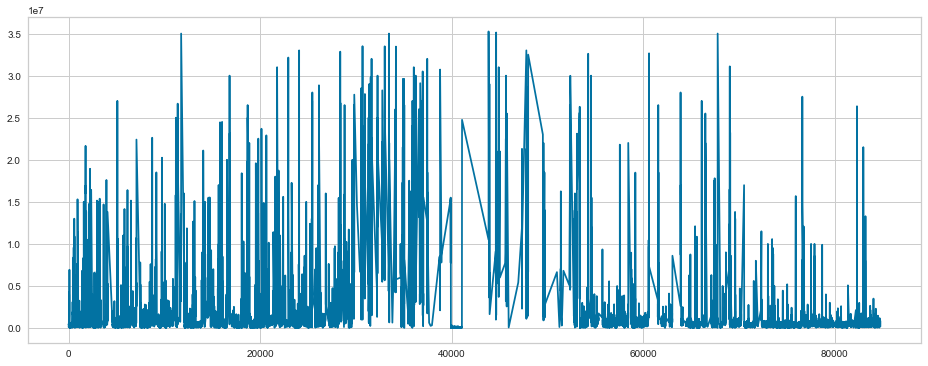

In [122]:
# Prices dist
plt.figure(figsize=(16,6))
prices = properties['price']
plt.plot(prices)

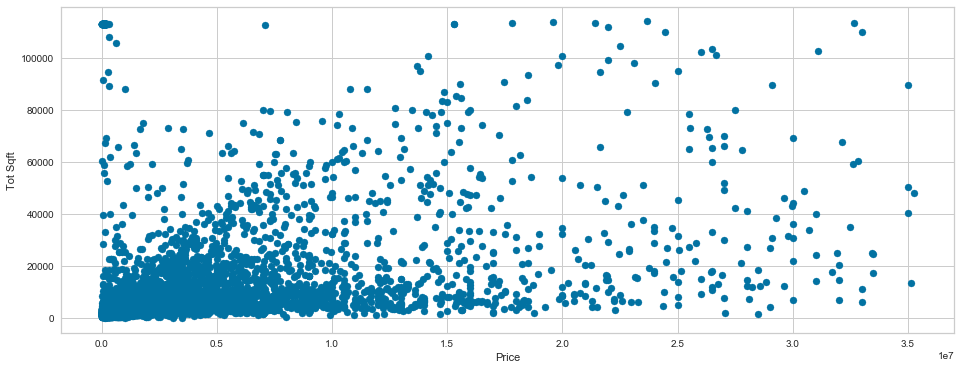

In [123]:
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.ylabel("Tot Sqft")
plt.scatter(properties['price'], properties['tot_sqft'])

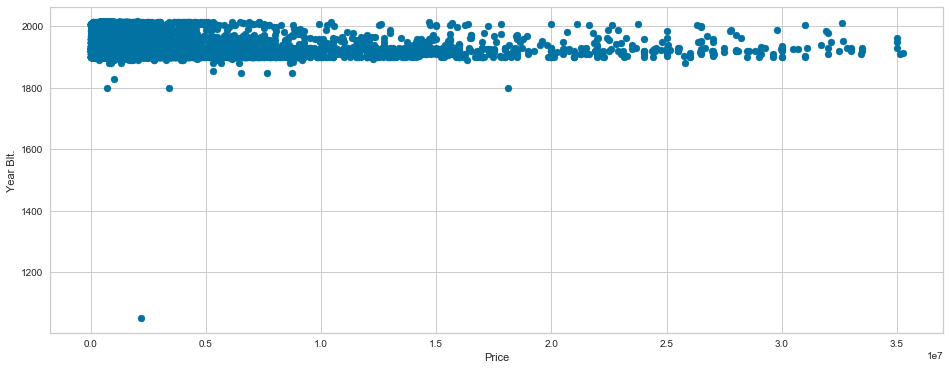

In [124]:
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.ylabel("Year Blt.")
plt.scatter(properties['price'], properties['yr_built'])

In [125]:
# correlation_matrix = properties.corr()

In [126]:
# hm = plt.subplots(figsize=(20,20)) 
# hm = sns.heatmap(correlation_matrix,
#                  cbar=True,
#                  annot=True,
#                  square=True,
#                  annot_kws={'size': 15},
#                  yticklabels=properties.columns,
#                  xticklabels=properties.columns)

# plt.tight_layout()

# Regression Analysis

## Data split

In [127]:
property_prices = properties['price']

In [128]:
properties = properties.drop(['price'], axis=1)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(properties, property_prices, test_size=0.1, random_state=42)

## Linear Reg.

In [130]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# R^2 scores
print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

Train: 0.5294305905137444
Test: 0.486411577800732


In [139]:
scores = cross_val_score(estimator=lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print("Scores", scores)
print("Mean Score:", np.mean(scores))

Scores [0.47185832 0.3689202  0.47378462 0.51144091 0.47679237 0.52827295
 0.52570228 0.42561116 0.41384776 0.50800626]
Mean Score: 0.47042368284967573


## Lasso Reg.

In [137]:
lasso = Lasso(alpha=20)
lasso_model = lasso.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
# R^2 scores

r2_score(y_test, y_pred)

/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6432313119694936e+16, tolerance: 19665512247880.105
  positive)


0.4808109911262054

In [138]:
scores = cross_val_score(estimator=lasso, X=X_train, y=y_train, cv=10, n_jobs=-1)
print("Scores", scores)
print("Mean Score:", np.mean(scores))

Scores [0.47410688 0.37203018 0.47899861 0.51250835 0.48287287 0.52046634
 0.5280382  0.43059838 0.41457925 0.50488846]
Mean Score: 0.4719087527600581


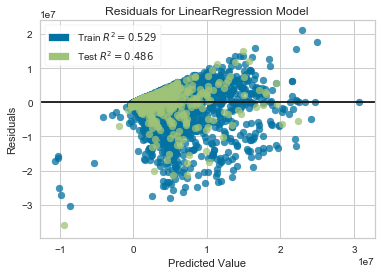

In [132]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Gradient Boost

In [141]:
gb_2 = GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=True)
gb_2.fit(X_train, y_train)
gb_2_predicted = gb_2.predict(X_test)

print('Score on training', gb_2.score(X_train, y_train))
print("Score on test:", r2_score(y_test, rf_2_predicted))

      Iter       Train Loss   Remaining Time 
         1 6557011553807.0352            3.78m
         2 5454490215497.3213            3.78m
         3 4549943466527.1387            3.73m
         4 3801348666105.1211            3.73m
         5 3188327160287.2046            3.71m
         6 2673999075144.5752            3.70m
         7 2259491248812.4644            3.71m
         8 1910386244108.2034            3.73m
         9 1622228085191.4604            3.73m
        10 1385524534958.8953            3.72m
        20 355902517363.1935            3.59m
        30 162790364947.8172            3.28m
        40 109387593264.2791            2.91m
        50 90443661697.4153            2.53m
        60 79206051264.7217            2.24m
        70 72174023149.5554            2.03m
        80 69396397906.2146            1.78m
        90 66308571344.6054            1.57m
       100 63516363733.7451            1.37m
       200 44358900270.8789            0.00s
Score on training 0.99438924716

In [ ]:
gb_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': gb_2_predicted})
plt.figure(figsize=(16,4))
plt.title("Gradient Boost Outcome")
plt.plot('entry', 'observed', data=gb_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=gb_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

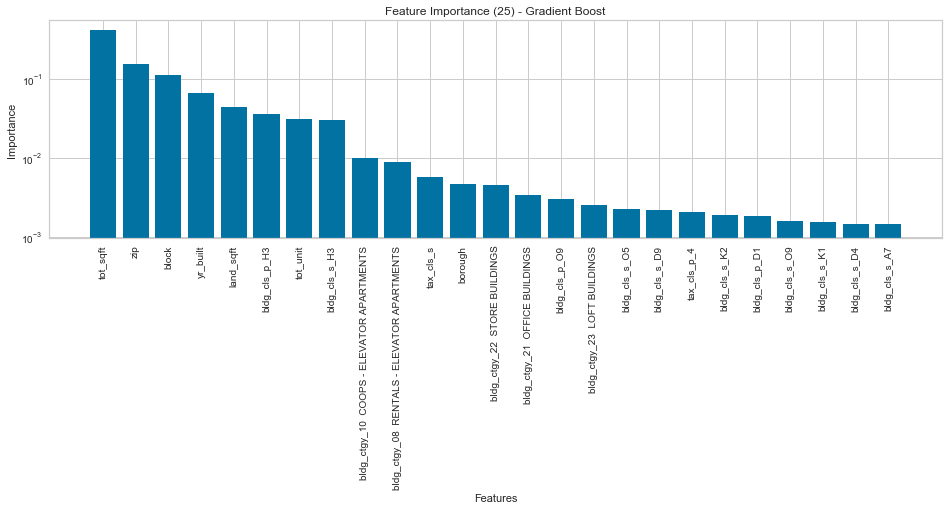

In [146]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(properties)
df_feature_importance['importance'] = gb_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(16,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Gradient Boost')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

## Random Forrest

In [136]:
rf_2 = RandomForestRegressor(n_estimators=200,criterion='mse',max_depth=20,random_state=42, verbose=True)
rf_2.fit(X_train, y_train)
rf_2_predicted = rf_2.predict(X_test)

print("R^2 score:", r2_score(y_test, rf_2_predicted))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R^2 score: 0.7284867175157804


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   42.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


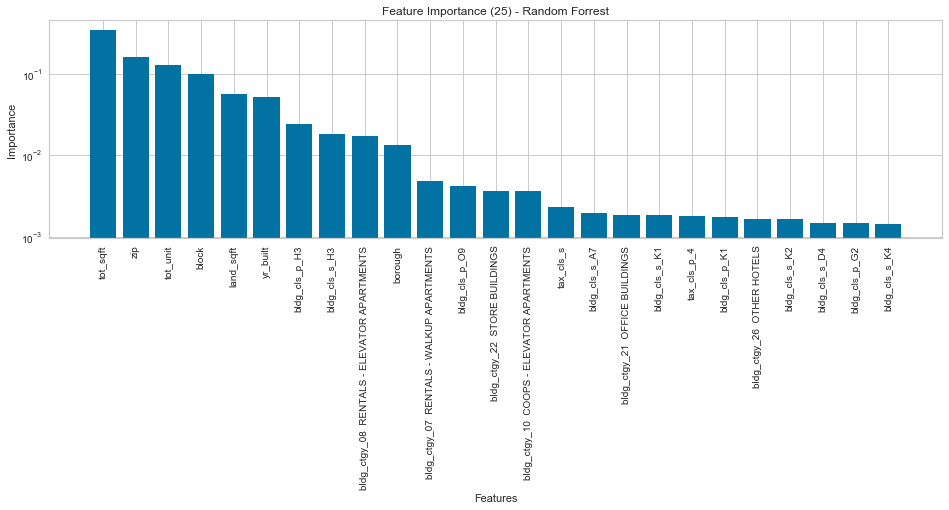

In [147]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(properties)
df_feature_importance['importance'] = rf_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(16,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Random Forrest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()